In [1]:
import pandas as pd

df = pd.read_csv('Processed_Specificities_Data.csv')

In [2]:
df = df[df['Target Name'] != 'P2X purinoceptor 4']
df = df.dropna()

df = pd.get_dummies(df, columns=['Target Name'])

print(df.head())

   Molecular Weight  AlogP                                             Smiles  \
0            497.60   4.39  COc1ccc(CC(=O)N2CCN(/C(=N/C#N)Nc3ccccc3C)CC2c2...   
1            438.81   4.65  O=C(c1cccc(C(F)(F)F)c1Cl)N1CCc2c(ncn2-c2ccccn2...   
2            473.80   5.76  O=C(c1cccc(C(F)(F)F)c1Cl)N1CCc2c(nc(C(F)(F)F)n...   
3            438.81   4.84  C[C@H]1c2ncn(-c3ccc(F)cn3)c2CCN1C(=O)c1cccc(C(...   
4            437.82   5.44  C[C@H]1c2ncn(-c3ccc(F)cc3)c2CCN1C(=O)c1cccc(C(...   

     pValue  Target Name_Adenosine A2a receptor  \
0  6.853872                               False   
1  7.183759                               False   
2  6.897909                               False   
3  5.000000                               False   
4  5.690008                               False   

   Target Name_P2X purinoceptor 7  \
0                            True   
1                            True   
2                            True   
3                            True   
4                    

In [3]:
print(df.shape)

(4727, 7)


In [5]:
df.reset_index(drop=True, inplace=True)

print("Counts for each target:")
print("P2X purinoceptor 7:", df['Target Name_P2X purinoceptor 7'].sum())
print("Adenosine A2a receptor:", df['Target Name_Adenosine A2a receptor'].sum())
print("Voltage-gated L-type calcium channel alpha-1C subunit:", df['Target Name_Voltage-gated L-type calcium channel alpha-1C subunit'].sum())

Counts for each target:
P2X purinoceptor 7: 1103
Adenosine A2a receptor: 2503
Voltage-gated L-type calcium channel alpha-1C subunit: 1121


In [6]:
!pip install transformers torch

In [7]:
from transformers import AutoTokenizer, AutoModel
import torch

tokenizer = AutoTokenizer.from_pretrained("seyonec/ChemBERTa-zinc-base-v1")
model = AutoModel.from_pretrained("seyonec/ChemBERTa-zinc-base-v1")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [8]:
model.eval()

RobertaModel(
  (embeddings): RobertaEmbeddings(
    (word_embeddings): Embedding(767, 768, padding_idx=1)
    (position_embeddings): Embedding(514, 768, padding_idx=1)
    (token_type_embeddings): Embedding(1, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): RobertaEncoder(
    (layer): ModuleList(
      (0-5): 6 x RobertaLayer(
        (attention): RobertaAttention(
          (self): RobertaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): RobertaSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (dropout): 

In [9]:
# Function to encode SMILES and get embeddings
def get_embeddings(smiles):
    inputs = tokenizer(smiles, return_tensors="pt", padding=True)
    with torch.no_grad():
        outputs = model(**inputs)
    embeddings = outputs.last_hidden_state.mean(dim=1)
    return embeddings.numpy().flatten()

In [10]:
df['Embeddings'] = df['Smiles'].apply(get_embeddings)

In [11]:
print(df.head())

   Molecular Weight  AlogP                                             Smiles  \
0            497.60   4.39  COc1ccc(CC(=O)N2CCN(/C(=N/C#N)Nc3ccccc3C)CC2c2...   
1            438.81   4.65  O=C(c1cccc(C(F)(F)F)c1Cl)N1CCc2c(ncn2-c2ccccn2...   
2            473.80   5.76  O=C(c1cccc(C(F)(F)F)c1Cl)N1CCc2c(nc(C(F)(F)F)n...   
3            438.81   4.84  C[C@H]1c2ncn(-c3ccc(F)cn3)c2CCN1C(=O)c1cccc(C(...   
4            437.82   5.44  C[C@H]1c2ncn(-c3ccc(F)cc3)c2CCN1C(=O)c1cccc(C(...   

     pValue  Target Name_Adenosine A2a receptor  \
0  6.853872                               False   
1  7.183759                               False   
2  6.897909                               False   
3  5.000000                               False   
4  5.690008                               False   

   Target Name_P2X purinoceptor 7  \
0                            True   
1                            True   
2                            True   
3                            True   
4                    

In [13]:
df['Embedding Shape'] = df['Embeddings'].apply(lambda x: x.shape)

all_same_shape = df['Embedding Shape'].nunique() == 1
print("All embeddings have the same shape:", all_same_shape)

if not all_same_shape:
    print("Unique embedding shapes:", df['Embedding Shape'].unique())

if all_same_shape:
    print("Shape of embeddings:", df['Embedding Shape'].iloc[0])

All embeddings have the same shape: True
Shape of embeddings: (768,)


In [15]:
df_adenosine_a2a = df[df['Target Name_Adenosine A2a receptor']]
df_p2x_purinoceptor_7 = df[df['Target Name_P2X purinoceptor 7']]
df_cacna1c = df[df['Target Name_Voltage-gated L-type calcium channel alpha-1C subunit']]

In [56]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor

# Adenosine a2a target models

In [24]:
aX = np.array(df_adenosine_a2a['Embeddings'].tolist())
ay = df_adenosine_a2a['pValue'].values

aX_train, aX_test, ay_train, ay_test = train_test_split(aX, ay, test_size=0.2, random_state=42)

In [25]:
# Decision Tree Regressor
adt_model = DecisionTreeRegressor()
adt_model.fit(aX_train, ay_train)
ay_pred_dt = adt_model.predict(aX_test)
mse_adt = mean_squared_error(ay_test, ay_pred_dt)
r2_adt = r2_score(ay_test, ay_pred_dt)
print("Decision Tree Regression - MSE:", mse_adt, "R2:", r2_adt)

Decision Tree Regression - MSE: 1.044157091494118 R2: 0.3500243610323789


In [26]:
# Support Vector Machine Regressor
asvm_model = SVR()
asvm_model.fit(aX_train, ay_train)
ay_pred_svm = asvm_model.predict(aX_test)
mse_asvm = mean_squared_error(ay_test, ay_pred_svm)
r2_asvm = r2_score(ay_test, ay_pred_svm)
print("SVM Regression - MSE:", mse_asvm, "R2:", r2_asvm)

SVM Regression - MSE: 0.7524697652540674 R2: 0.5315963273543658


In [27]:
import xgboost as xgb

# XGBoost Regressor
axgb_model = xgb.XGBRegressor(objective='reg:squarederror')
axgb_model.fit(aX_train, ay_train)
ay_pred_xgb = axgb_model.predict(aX_test)
mse_axgb = mean_squared_error(ay_test, ay_pred_xgb)
r2_axgb = r2_score(ay_test, ay_pred_xgb)
print("XGBoost Regression - MSE:", mse_axgb, "R2:", r2_axgb)

XGBoost Regression - MSE: 0.6863186056770604 R2: 0.5727746544133612


In [28]:
# MLP Regressor
amlp_model = MLPRegressor(max_iter=500)
amlp_model.fit(aX_train, ay_train)
ay_pred_mlp = amlp_model.predict(aX_test)
mse_amlp = mean_squared_error(ay_test, ay_pred_mlp)
r2_amlp = r2_score(ay_test, ay_pred_mlp)
print("MLP Regression - MSE:", mse_amlp, "R2:", r2_amlp)

MLP Regression - MSE: 0.7734632636343427 R2: 0.518528118906574


In [29]:
# Ridge Regression
aridge_model = Ridge()
aridge_model.fit(aX_train, ay_train)
ay_pred_ridge = aridge_model.predict(aX_test)
mse_aridge = mean_squared_error(ay_test, ay_pred_ridge)
r2_aridge = r2_score(ay_test, ay_pred_ridge)
print("Ridge Regression - MSE:", mse_aridge, "R2:", r2_aridge)

Ridge Regression - MSE: 0.7036571698055611 R2: 0.5619816000061195


In [30]:
# Lasso Regression
alasso_model = Lasso()
alasso_model.fit(aX_train, ay_train)
ay_pred_lasso = alasso_model.predict(aX_test)
mse_alasso = mean_squared_error(ay_test, ay_pred_lasso)
r2_alasso = r2_score(ay_test, ay_pred_lasso)
print("Lasso Regression - MSE:", mse_alasso, "R2:", r2_alasso)

Lasso Regression - MSE: 1.6077938018857996 R2: -0.0008329323450180226


In [31]:
# Random Forest Regressor
arf_model = RandomForestRegressor()
arf_model.fit(aX_train, ay_train)
ay_pred_rf = arf_model.predict(aX_test)
mse_arf = mean_squared_error(ay_test, ay_pred_rf)
r2_arf = r2_score(ay_test, ay_pred_rf)
print("Random Forest Regression - MSE:", mse_arf, "R2:", r2_arf)

Random Forest Regression - MSE: 0.6050597140066977 R2: 0.6233573688971256


In [57]:
X_p2x = np.array(df_p2x_purinoceptor_7['Embeddings'].tolist())
predicted_pValues_aa2a = arf_model.predict(X_p2x)

df_p2x_purinoceptor_7.loc[:, 'Predicted pValue for AA2A'] = predicted_pValues_aa2a

# Cacna1c Target models

In [33]:
cX = np.array(df_cacna1c['Embeddings'].tolist())
cy = df_cacna1c['pValue'].values

cX_train, cX_test, cy_train, cy_test = train_test_split(cX, cy, test_size=0.2, random_state=42)

In [34]:
# Decision Tree Regressor
cdt_model = DecisionTreeRegressor()
cdt_model.fit(cX_train, cy_train)
cy_pred_dt = cdt_model.predict(cX_test)
mse_cdt = mean_squared_error(cy_test, cy_pred_dt)
r2_cdt = r2_score(cy_test, cy_pred_dt)
print("Decision Tree Regression - MSE:", mse_cdt, "R2:", r2_cdt)

Decision Tree Regression - MSE: 0.8007015774511453 R2: -0.9033858556719094


In [36]:
# XGBoost Regressor
cxgb_model = xgb.XGBRegressor(objective='reg:squarederror')
cxgb_model.fit(cX_train, cy_train)
cy_pred_xgb = cxgb_model.predict(cX_test)
mse_cxgb = mean_squared_error(cy_test, cy_pred_xgb)
r2_cxgb = r2_score(cy_test, cy_pred_xgb)
print("XGBoost Regression - MSE:", mse_cxgb, "R2:", r2_cxgb)

XGBoost Regression - MSE: 0.34602793714260305 R2: 0.1774405099573505


In [37]:
# MLP Regressor
cmlp_model = MLPRegressor(max_iter=500)
cmlp_model.fit(cX_train, cy_train)
cy_pred_mlp = cmlp_model.predict(cX_test)
mse_cmlp = mean_squared_error(cy_test, cy_pred_mlp)
r2_cmlp = r2_score(cy_test, cy_pred_mlp)
print("MLP Regression - MSE:", mse_cmlp, "R2:", r2_cmlp)

MLP Regression - MSE: 0.32107303358208816 R2: 0.23676199976625334


In [38]:
# Ridge Regression
cridge_model = Ridge()
cridge_model.fit(cX_train, cy_train)
cy_pred_ridge = cridge_model.predict(cX_test)
mse_cridge = mean_squared_error(cy_test, cy_pred_ridge)
r2_cridge = r2_score(cy_test, cy_pred_ridge)
print("Ridge Regression - MSE:", mse_cridge, "R2:", r2_cridge)

Ridge Regression - MSE: 0.3058776855373271 R2: 0.27288358532935253


In [39]:
# Lasso Regression
classo_model = Lasso()
classo_model.fit(cX_train, cy_train)
cy_pred_lasso = classo_model.predict(cX_test)
mse_classo = mean_squared_error(cy_test, cy_pred_lasso)
r2_classo = r2_score(cy_test, cy_pred_lasso)
print("Lasso Regression - MSE:", mse_classo, "R2:", r2_classo)

Lasso Regression - MSE: 0.42722916909266645 R2: -0.015586805973365259


In [40]:
# Random Forest Regressor
crf_model = RandomForestRegressor()
crf_model.fit(cX_train, cy_train)
cy_pred_rf = crf_model.predict(cX_test)
mse_crf = mean_squared_error(cy_test, cy_pred_rf)
r2_crf = r2_score(cy_test, cy_pred_rf)
print("Random Forest Regression - MSE:", mse_crf, "R2:", r2_crf)

Random Forest Regression - MSE: 0.29821779524564324 R2: 0.29109227536790705


In [35]:
# Support Vector Machine Regressor
csvm_model = SVR()
csvm_model.fit(cX_train, cy_train)
cy_pred_svm = csvm_model.predict(cX_test)
mse_csvm = mean_squared_error(cy_test, cy_pred_svm)
r2_csvm = r2_score(cy_test, cy_pred_svm)
print("SVM Regression - MSE:", mse_csvm, "R2:", r2_csvm)

SVM Regression - MSE: 0.2632987161992788 R2: 0.37410008129919337


In [58]:
predicted_pValues_cacna1c = csvm_model.predict(X_p2x)

df_p2x_purinoceptor_7.loc[:, 'Predicted pValue for CACNA1C'] = predicted_pValues_cacna1c

In [59]:
sorted_df_desc = df_p2x_purinoceptor_7.sort_values(by='pValue', ascending=False)

print(sorted_df_desc[['Smiles', 'pValue', 'Predicted pValue for AA2A', 'Predicted pValue for CACNA1C']])

                                                 Smiles    pValue  \
546   C[C@H]1Cn2c(nnc2-c2ncccn2)C(=O)N1Cc1cccc(C(F)(...  9.397940   
1064  C[C@H]1Cn2c(nnc2-c2cscn2)C(=O)N1Cc1cccc(C(F)(F...  9.397940   
166   CN1CCc2c(cccc2C(=O)NCC2(N3CCN(c4ccccc4)CC3)CCC...  9.100015   
1044  C[C@H]1Cc2c(nnn2-c2ncccn2)CN1C(=O)c1cccc(C(F)(...  9.000000   
180   Cc1nc2c(c(-c3ccn[nH]3)n1)C[C@H](C)N(C(=O)c1ccc...  9.000000   
...                                                 ...       ...   
855        C[C@H]1Cn2c(nnc2-c2cnccn2)C(=O)N1Cc1ccccc1Cl  4.383000   
901   C[C@@H]1Cc2c(nnn2-c2ncc(F)cn2)CN1C(=O)c1ccc(F)...  4.335000   
122   Cc1nc(/N=N/c2ccc(S(=O)(=O)O)cc2S(=O)(=O)O)c(CO...  4.207608   
564   O=C1CSC(=O)N1C(CCc1ccncc1)COc1ccc(-c2cccc([N+]...  4.000000   
453   CN([C@@H](Cc1ccc(OS(=O)(=O)c2cccc3cnccc23)cc1)...  4.000000   

      Predicted pValue for AA2A  Predicted pValue for CACNA1C  
546                    5.943103                      5.402726  
1064                   5.918187            

In [61]:
df_p2x_purinoceptor_7.loc[:, 'Specificity to p2rx7 over Aa2a'] = df_p2x_purinoceptor_7['pValue'] - df_p2x_purinoceptor_7['Predicted pValue for AA2A']
df_p2x_purinoceptor_7.loc[:, 'Specificity to p2rx7 over Cacna1c'] = df_p2x_purinoceptor_7['pValue'] - df_p2x_purinoceptor_7['Predicted pValue for CACNA1C']

In [62]:
# Sorting the DataFrame by 'Difference in pValue' in descending order
sorted_difference_df_aa2a = df_p2x_purinoceptor_7.sort_values(by='Specificity to p2rx7 over Aa2a', ascending=False)
sorted_difference_df_cacna1c = df_p2x_purinoceptor_7.sort_values(by='Specificity to p2rx7 over Cacna1c', ascending=False)

print(sorted_difference_df_aa2a[['Smiles', 'pValue', 'Predicted pValue for AA2A', 'Predicted pValue for CACNA1C', 'Specificity to p2rx7 over Aa2a']].head())
print(sorted_difference_df_cacna1c[['Smiles', 'pValue', 'Predicted pValue for AA2A', 'Predicted pValue for CACNA1C', 'Specificity to p2rx7 over Cacna1c']].head())

                                                 Smiles    pValue  \
1064  C[C@H]1Cn2c(nnc2-c2cscn2)C(=O)N1Cc1cccc(C(F)(F...  9.397940   
546   C[C@H]1Cn2c(nnc2-c2ncccn2)C(=O)N1Cc1cccc(C(F)(...  9.397940   
166   CN1CCc2c(cccc2C(=O)NCC2(N3CCN(c4ccccc4)CC3)CCC...  9.100015   
1100    O=C(NCC12CC3CC(CC(C3)C1)C2)c1cc(CCCNCCCO)ccc1Cl  8.356547   
70    C[C@H]1Cn2c(nnc2-c2cnccn2)C(=O)N1Cc1cccc(C(F)(...  8.958607   

      Predicted pValue for AA2A  Predicted pValue for CACNA1C  \
1064                   5.918187                      5.410048   
546                    5.943103                      5.402726   
166                    5.786373                      4.985414   
1100                   5.075548                      4.924644   
70                     5.879186                      5.404525   

      Specificity to p2rx7 over Aa2a  
1064                        3.479753  
546                         3.454837  
166                         3.313643  
1100                        3.281000  

In [63]:
!pip install rdkit-pypi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 33.0 MB/s eta 0:00:00


SMILES: C[C@H]1Cn2c(nnc2-c2cscn2)C(=O)N1Cc1cccc(C(F)(F)F)c1Cl -> Molecular Formula: C17H13ClF3N5OS
pValue (P2RX7): 9.397940008672036
Predicted pValue for AA2A: 5.9181874115946345
Predicted pValue for CACNA1C: 5.410048302797032


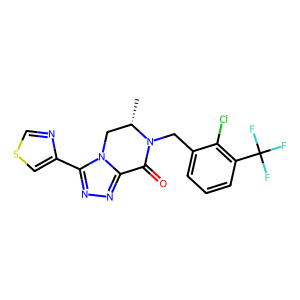


---

SMILES: C[C@H]1Cn2c(nnc2-c2ncccn2)C(=O)N1Cc1cccc(C(F)(F)F)c1Cl -> Molecular Formula: C18H14ClF3N6O
pValue (P2RX7): 9.397940008672036
Predicted pValue for AA2A: 5.94310298787252
Predicted pValue for CACNA1C: 5.4027255759793364


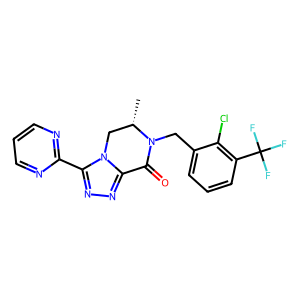


---

SMILES: CN1CCc2c(cccc2C(=O)NCC2(N3CCN(c4ccccc4)CC3)CCCCC2)C1 -> Molecular Formula: C28H38N4O
pValue (P2RX7): 9.100015437450608
Predicted pValue for AA2A: 5.786372572255042
Predicted pValue for CACNA1C: 4.985414150898903


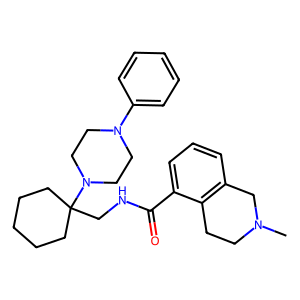


---



In [68]:
# Printing molecules with best specificities to P2RX7

from rdkit import Chem
from rdkit.Chem import Draw, rdMolDescriptors

indices = [1064, 546, 166]

valid_indices = [idx for idx in indices if idx in df_p2x_purinoceptor_7.index]

for idx in valid_indices:
    row = df_p2x_purinoceptor_7.loc[idx]
    smiles = row['Smiles']
    pvalue = row['pValue']
    predicted_pvalue_aa2a = row['Predicted pValue for AA2A']
    predicted_pvalue_cacna1c = row.get('Predicted pValue for CACNA1C')

    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        formula = Chem.rdMolDescriptors.CalcMolFormula(mol)
        print(f"SMILES: {smiles} -> Molecular Formula: {formula}")
    else:
        print(f"SMILES: {smiles} -> Error: Invalid SMILES string")

    print(f"pValue (P2RX7): {pvalue}")
    print(f"Predicted pValue for AA2A: {predicted_pvalue_aa2a}")
    print(f"Predicted pValue for CACNA1C: {predicted_pvalue_cacna1c}")

    display(Draw.MolToImage(mol))

    print("\n---\n")